# DegreeDiscountIC (a.k.a the ORACLE)

In [1]:
import networkx as nx
import numpy as np
from numpy.random import default_rng
rng = default_rng(12345)
import matplotlib.pyplot as plt
import sys; sys.path.append("model-independent-cascade\src")
from influence import influence_count
from scipy.stats import norm

Generating a random graph to test-run the model

In [2]:
G = nx.fast_gnp_random_graph(300, 0.1, directed=True)
edges = list(G.edges())

In [3]:
def sample_edges(edges, C, P_hat, O):
    epo = [(edges[i], P_hat[i], O[i]) for i in range(len(edges))]
    E = [[] for i in range(10)]
    for i in range(len(edges)):
        index = min(int(epo[i][1]/0.1), 9)
        E[index].append(epo[i])
    E_hat = []
    for i in range(10):
        E[i].sort(key=lambda tuple: tuple[2], reverse=True)
        c_i = int(len(E[i])/(len(edges))*C)+1
        E_hat = E_hat + E[i][:c_i]

    return E_hat

In [4]:
def oracle(G, k, P):
    S = set({})
    temp = list(nx.degree(G))
    dd = d = [d for (_,d) in temp]
    t = [0 for _ in range(len(d))]

    for _ in range(k):
        u = np.argmax(dd)
        dd[u] = -1
        S.add(u)
        neighbors = set(G.neighbors(u))
        for v in (neighbors-S):
            p = P[edges.index((u, v))]
            t[v] += 1
            dd[v] = d[v] - 2*t[v] - (d[v] - t[v])*t[v]*p

    return list(S)

## The Algorithm: piece-by-piece

Coding it step-by-step:

Assigning the _ground-truth_ edge features and initializing the embeddings

In [5]:
for e in edges:
    n1, n2 = e
    alpha_t = rng.uniform(size=4)
    alpha_t /= np.linalg.norm(alpha_t)
    beta_t = rng.uniform(size=4)
    beta_t /= np.linalg.norm(beta_t)
    
    G.edges[n1,n2]['xt'] = np.concatenate((alpha_t, beta_t))

    alpha = rng.uniform(size=4)
    alpha /= np.linalg.norm(alpha)
    beta = rng.uniform(size=4)
    beta /= np.linalg.norm(beta)
    
    G.edges[n1,n2]['x'] = np.concatenate((alpha, beta))


Initializing hyperparameters for the algorithm:

In [7]:
sigma = 1
C = 80
horizon = 200
period = 10
alpha = 0.001
z = 2

P_hat = [0 for _ in range(len(edges))]  
O = [0 for _ in range(len(edges))]
B = [0 for _ in range(len(edges))]

Sampling edges according to algorithm 2:

In [8]:
Cedges = [a for (a,b,c) in sample_edges(edges, C, P_hat, O)]

Writing the kernel function

In [6]:
f = lambda x1,x2: np.exp(-1)*(np.linalg.norm(x1-x2)**2)

1. Contructing matrix X and Y using the sampled edges
2. Computing the matrix $\text{A}$, $\text{A}^{-1}$ and $\text{J}$ = $\text{A}^{-1} \hat{\text{Y}}$

In [10]:
X = np.array([G.edges[e]['x'] for e in Cedges])
Y = np.array([P_hat[edges.index(e)] for e in Cedges])
n = X.shape[0]
A = np.array([[f(x1,x2) for x2 in X] for x1 in X]).reshape((n, n)) + (sigma**2)*np.identity(n)
A_inv = np.linalg.inv(A)
J = np.dot(A_inv, Y)

U = [0 for _ in range(len(edges))]
m = [0 for _ in range(len(edges))]
var = [0 for _ in range(len(edges))]

Computing the mean and variance for each edge using the Gaussian Process Regression

In [11]:
for i in range(len(edges)):
    xi = G.edges[edges[i]]['x']
    K_i = np.array([f(xi, x1) for x1 in X]).reshape(n,1)
    mi = np.dot(K_i.T, J)
    vari = (sigma**2) - np.dot(K_i.T, np.dot(A_inv, K_i))
    u = norm.cdf(mi + z*np.sqrt(vari))
    U[i] = u
    m[i] = mi
    var[i] = vari

In [12]:
U = np.array(U).reshape(-1,1)

Generating the seed set using the UCBs. 

In [13]:
S = oracle(G, 30, U)

Simulating the information diffusion process using this seed set:

In [14]:
total_influenced_nodes, observed_edges, O, B = influence_count(G, S, edges, O, B)

Updating the probabilities and edge embeddings for observed edges:

In [15]:
for i in observed_edges:
    P_hat[i] = B[i]/O[i]
    xi = G.edges[edges[i]]['x']
    delta = (m[i] - P_hat[i])*2*np.exp(-1)*np.dot((np.array([xi for _ in range(X.shape[0])])-X).T, J.reshape(-1,1))
    G.edges[edges[i]]['x'] = xi - alpha*delta

We also need to update the Kernel matrix periodically:

In [19]:
if horizon % period == 0:
    Cedges = [a for (a,b,c) in sample_edges(edges, C, P_hat, O)]
    X = np.array([G.edges[e]['x'] for e in Cedges])
    Y = np.array([P_hat[edges.index(e)] for e in Cedges])
    n = X.shape[0]
    A = np.array([[f(x1,x2) for x2 in X] for x1 in X]).reshape((n, n)) + (sigma**2)*np.identity(n)
    A_inv = np.linalg.inv(A)
    J = np.dot(A_inv, Y)

## Patching Everything Up:

In [7]:
sigma = 1
C = 80
horizon = 200
period = 10
alpha = 0.001
z = 2

P_hat = [0 for _ in range(len(edges))]  
O = [0 for _ in range(len(edges))]
B = [0 for _ in range(len(edges))]

Cedges = [a for (a,b,c) in sample_edges(edges, C, P_hat, O)]

X = np.array([G.edges[e]['x'] for e in Cedges])
Y = np.array([P_hat[edges.index(e)] for e in Cedges])
n = X.shape[0]
A = np.array([[f(x1,x2) for x2 in X] for x1 in X]).reshape((n, n)) + (sigma**2)*np.identity(n)
A_inv = np.linalg.inv(A)
J = np.dot(A_inv, Y)

U = [0 for _ in range(len(edges))]
m = [0 for _ in range(len(edges))]
var = [0 for _ in range(len(edges))]

In [8]:
results = []

In [9]:
for epoch in range(horizon):
    for i in range(len(edges)):
        xi = G.edges[edges[i]]['x']
        K_i = np.array([f(xi, x1) for x1 in X]).reshape(n,1)
        mi = np.dot(K_i.T, J)
        vari = max(0, (sigma**2) - np.dot(K_i.T, np.dot(A_inv, K_i)))
        u = norm.cdf(mi + z*np.sqrt(vari))
        U[i] = u
        m[i] = mi
        var[i] = vari

    S = oracle(G, 30, U)
    total_influenced_nodes, observed_edges, O, B = influence_count(G, S, edges, O, B)
    results.append(total_influenced_nodes)

    for i in observed_edges:
        P_hat[i] = B[i]/O[i]
        xi = G.edges[edges[i]]['x']
        delta = (m[i] - P_hat[i])*2*np.exp(-1)*np.dot((np.array([xi for _ in range(X.shape[0])])-X).T, J)
        G.edges[edges[i]]['x'] = xi - alpha*delta

    if horizon % period == 0:
        Cedges = [a for (a,b,c) in sample_edges(edges, C, P_hat, O)]
        X = np.array([G.edges[e]['x'] for e in Cedges])
        Y = np.array([P_hat[edges.index(e)] for e in Cedges])
        n = X.shape[0]
        A = np.array([[f(x1,x2) for x2 in X] for x1 in X]).reshape((n, n)) + (sigma**2)*np.identity(n)
        A_inv = np.linalg.inv(A)
        J = np.dot(A_inv, Y)

C:\Users\Tushar\AppData\Local\Temp/ipykernel_20108/2341370888.py:7: RuntimeWarning: invalid value encountered in sqrt
  u = norm.cdf(mi + z*np.sqrt(vari))
C:\Users\Tushar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\stats\_distn_infrastructure.py:1956: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


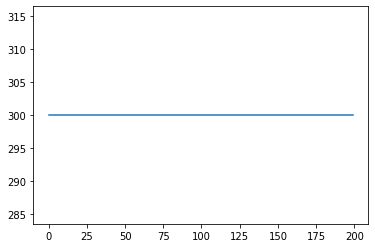

In [10]:
plt.plot(results)